## LISTA 2 Aprendizagem de máquina (CK0193)
## Aluno: Lucas Rodrigues Aragão (538390)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Criação dos modelos

## Função auxiliar 

In [2]:
def global_accuracy_function(true_values: np.array,predicted: np.array):

  if len(true_values) != len(predicted):
    return 'erro de tamanho'

  num_erros = 0
  num_acertos = 0

  for i, prediction in enumerate(predicted):
    if true_values[i] == prediction:
      num_acertos +=1
    else:
      num_erros +=1
  return num_acertos/(num_acertos + num_erros)


def kfold(model ,features_data, label_data, num_folds = 10):
    """
    funcao para fazer a validacao cruzada
    model: modelo de ML
    features data: X dos dados que serao usados no modelo
    label data: y dos dados que serao usados no modelo
    num_folds: numero de folds
    """

    # recebers dados de features e labels separados
    # esses dados podem estar do jeito que vieram sem alteraçoes
    #em tese o algoritmo ja recebe os dados embaralhados, por isso apenas pega as particoes
    tamanho_particoes =  int(np.ceil(len(features_data)/num_folds))

    #uma particao tera um tamanho menor que as demais caso os tamanhos sejam desiguais
    if tamanho_particoes*num_folds > len(features_data):
        ultima = len(features_data) - tamanho_particoes*(num_folds-1)
    
    inicio = 0
    fim= tamanho_particoes

    acuracias_globais = np.array([])
    acuracias_por_classe = {}
    curvas = []
    for i in range(num_folds):
      x_teste = features_data.iloc[inicio:fim]
      y_teste = label_data[inicio:fim]

      x_train_fold  = features_data.drop(features_data.index[inicio:fim])
      y_train_fold = label_data.drop(label_data.index[inicio:fim])
      scaler = StandardScaler()
      train_fold_normalizado = pd.DataFrame(scaler.fit_transform(x_train_fold), columns= x_train_fold.columns, index = x_train_fold.index)
      x_train_fold = train_fold_normalizado.copy()
      x_teste_normalizado = pd.DataFrame(scaler.transform(x_teste), columns= x_teste.columns, index= x_teste.index)
      x_teste = x_teste_normalizado.copy()

      train = pd.concat([x_train_fold, y_train_fold], axis=1)
      train.columns = list(x_train_fold.columns) + ['label']
      
      model.fit(train)
      predictions = model.predict(x_teste)

      if isinstance(model, LogisticRegressionGD) or isinstance(model, LogisticRegressionSoftmaxGD ):
        curvas.append(model.erros)

      #calcular as metricas
      
      #por classe    
      
      y_teste = np.array(y_teste)

      for classe in np.unique(y_teste):
        acerto_classe = 0   
        total_classe = 0
        for i, elemento in enumerate(list(y_teste)):
          if elemento == classe:
            total_classe +=1
            if predictions[i] == classe:
               acerto_classe +=1

        acc = acerto_classe/total_classe
        if classe not in acuracias_por_classe:
                acuracias_por_classe[classe] = []
        acuracias_por_classe[classe].append(acc)
      
      # global 
      acuracia_global = global_accuracy_function(y_teste, predictions)
      acuracias_globais = np.append(acuracias_globais, acuracia_global)

      #trocar o fold 
      if i+1 == num_folds -1:
          fim += ultima
      
      else: 
          fim += tamanho_particoes
      inicio +=tamanho_particoes

    # Plotar curvas de aprendizado
    if isinstance(model, LogisticRegressionGD) or isinstance(model, LogisticRegressionSoftmaxGD) :
      fig, axes = plt.subplots(2, 5, figsize=(20, 10))
      axes = axes.ravel()

      for i, curva in enumerate(curvas):
          norma = np.linalg.norm(curva)
          erros_normalizados = curva / norma
          axes[i].plot(erros_normalizados)
          axes[i].set_title(f'Fold {i+1}')
          axes[i].set_xlabel('Iteração')
          axes[i].set_ylabel('Log Loss')

      plt.tight_layout()
      plt.show()

    for classe, acuracias in acuracias_por_classe.items():
        media_classe = np.mean(acuracias)
        print(f'A acurácia para a classe {classe} foi igual a {media_classe}')

    media = acuracias_globais.mean()    
    print(f'a acuracia global media do modelo foi igual a: {media}')


## Regressão logística Binária

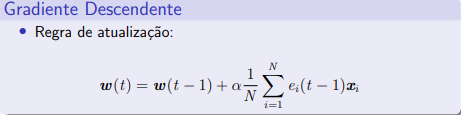

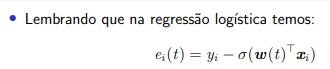

Em que,

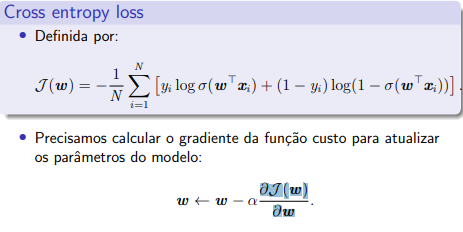

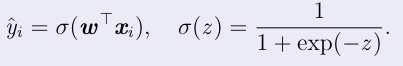




In [3]:
class LogisticRegressionGD():
    def __init__(self, alfa, t = None):
        '''
        cria o modelo do tipo LogisticRegressionGD
        alfa(positive float): tamanho do passo em cada iteração, recomenda-se um valor pequeno
        t(int, optional): número de passos
        '''
        self.alfa = alfa

        if t == None:
            self.t = 500
        else:
            self.t = t
    
    def sigmoide(self,z):
        """
        retorna o valor da funcao sigmoide para um valor z
        """
        z = np.clip(z, -500, 500)
        return 1/(1+ np.exp(-z))
    
    def plot_curva_aprendizado(self):
        '''
        cria um grafico contabilizando os erros do modelo ao longo das épocas do modelo
        '''
        erros = self.erros
        
        norma = np.linalg.norm(erros)
        erros_normalizados = erros/norma

        plt.plot(erros_normalizados)
        plt.xlabel('iteraçao')
        plt.ylabel('log_loss')
        plt.title('curva de aprendizagem ao longo das iteracoes')
        
        plt.show()

    def fit(self, train):
        '''
        faz o modelo se adequar ao conjunto de dados de treino
        x(np.array): array com o x do conjunto de dados
        y_true(np.array): valores verdadeiros de y do conjunto de dados
        '''
        x_train = train.iloc[:,:-1]
        y_train = train.iloc[:,-1:]
        

        #adcionando coluna de uns na esquerda de x_train
        x = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        y_train = np.array(y_train)
        #criando o vetor w
        w = np.random.randn(x.shape[1]) * 0.01
        #lista de erros 
        lista_erros = []
        y_pred = np.zeros((x.shape[0]))

        for j in range (self.t):

            #calcular os y_preditos pelo modelo                
            predicao = np.dot(x, w)
            y_pred = self.sigmoide(predicao)
            
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)


            #atualizar o erro
            erro = y_pred - y_train.flatten()

            #atualizar os parametros
            w -= self.alfa * (1/x.shape[0]) * np.dot(x.T, erro)
            
            #lista de erros, para futuras analises
            log_loss = -np.mean(y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred))
            lista_erros.append(np.sum(erro))
            
        self.w = w
        self.erros = lista_erros 

    def predict_probabilities(self, x_test):
        """
        retorna a probabilidade de cada item do conjunto de teste
        o valor sera entre 0 e 1
        """
        # basicamente pegar o w que foi parametrizado e fitado no treino e aplicar para o conjuno de teste
        x = np.hstack((np.ones((x_test.shape[0], 1)), x_test))  
        predicao = np.dot(x, self.w.T)
        return self.sigmoide(predicao)
    
    def predict(self, x_test):
        """
        retorna a predicao para os dados de teste
        """
        y_pred = self.predict_probabilities(x_test)
        return (y_pred >= 0.5).astype(int)


## Naive Bayes Gaussiano

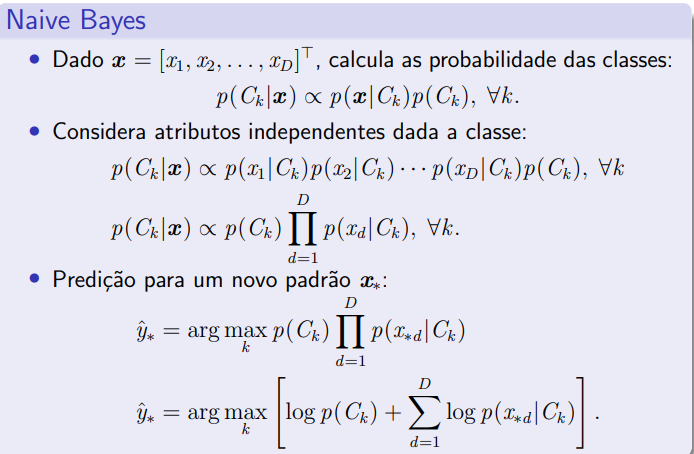

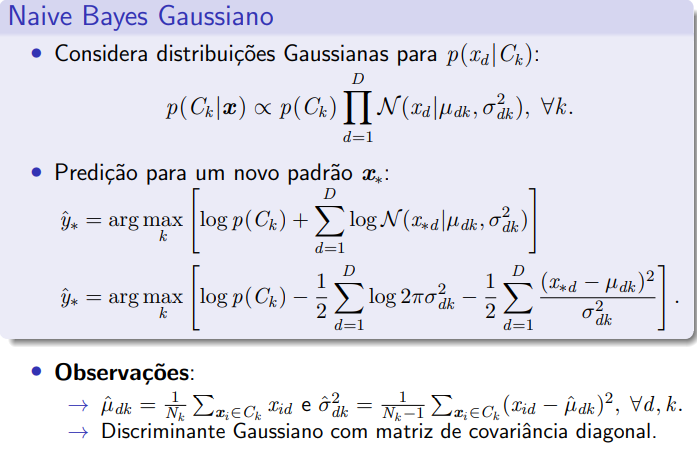

In [4]:
class NaiveBayesGaussiano():    
    # o primeiro passo eh calcular a probabilidade de cada classe
    # tendo essa probabilidade vamos calcular o y_pred para cada classe e vamos
    
    def __init__(self):
        """
        cria um modelo do tipo naive bayes, nao possui hiperparametros
        """
        pass

    def get_priori(self,train_data, class_data):
        """
        pega as probabilidades  de uma determinada classe dos dados de treino 
        """
        #pegar as prioris de cada classe
        prob = len(class_data)/len(train_data)
        return prob

    def get_means(self, x_class):
        """
        pega as medias de cada coluna de x dos dados de treino para determinada classe 
        """
        #aqui eh tirar a media de cada coluna e retornar uma lista com as medias dos elementos da classe               
        class_means = []
        for column in x_class:
            column_mean = x_class[column].mean()
            class_means.append(column_mean)
        return class_means
        

    def get_variance(self,x_class):
        """
        pega as variancias de cada coluna de x dos dados de treino para determinada classe 
        """
        #aqui eh tirar a variancia de cada caracteristica do dataset e retornar a lista com as variancias
        class_variances = []
        for column in x_class:
            column_variance = np.var(x_class[column], ddof= 1)
            class_variances.append(column_variance)
        return class_variances

    def fit(self, train_data):
        """
        aqui o modelo vai aprender sobre os dados de treino, descobrindo nessa fase as classes de predicao, prioris, medias de colunas e variancias destas
        """
        y = train_data.iloc[:,-1]
        prioris = []
        means_list = []
        variances_list = []

        for dif_class in y.unique():
            class_data = train_data.loc[train_data['label'] == dif_class]
            x_class = class_data.iloc[:, :-1]

            #pegar a priori da classe
            priori = self.get_priori(train_data, class_data)
            prioris.append(priori)

            #aqui eh pegar as medias da classe             
            means = self.get_means(x_class)
            means_list.append(means)

            #depois pegar as variancias da classe
            variances = self.get_variance(x_class)
            variances_list.append(variances)
        
        #em tese depois daqui eh so salvar os parametros acho 
        #a posicao de cada um vai ser igual em todas as listas
        self.classes = y.unique()
        self.prioris = prioris
        self.means_list = means_list
        self.variances_List = variances_list
    
    def prob_calc(self, pos, x):
        """
        aqui o modelo vai calcular a probabilidade de uma instancia de teste, x, fazer parte de determinada classe
        """
        log_class = np.log(self.prioris[pos])
        
        sum_means = 0
        sum_variances = 0
        class_means = self.means_list[pos]
        class_variances = self.variances_List[pos]
        for index, item in enumerate(x):
            #print(item)
            sum_means += ((item - class_means[index])**2)/class_variances[index]
            
            sum_variances += np.log(2* np.pi *class_variances[index])

        resul = log_class - ((1/2)*(sum_means + sum_variances)) 
        
        return resul

    def predict(self, x_test):                
        """
        aqui o o modelo vai prever as classes das instancias de treino
        """
        y_pred = []
        pred_prob_list = []
        #para cada elemento em x_teste fazer
        
        for index, row in x_test.iterrows():
            row_array = np.array(row)
            maior = - np.inf
            classe = 'nao calculada'
            x_pred_prob_list = []
            #para cada classe em self.classes
            for i, dif_class in enumerate(self.classes):
                # calcular o a prob de ser daquela classe 
                class_prob = self.prob_calc(pos = i, x = row_array)
                #print(class_prob)
                # se for prob(classe) > maior:
                x_pred_prob_list.append(class_prob)
                if class_prob > maior:
                    maior = class_prob
                    classe = dif_class
  
            # y_pred = classe de maior prob
            y_pred_row = classe
            pred_prob_list.append(pred_prob_list)
            y_pred.append(y_pred_row)


        return y_pred      
     

## Análise de Discriminante Gaussiano 

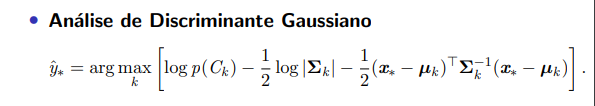

In [5]:
class Discriminante_Gaussiano():
   
   def __init__(self):
      """
      cria modelo do tipo discriminante gaussiano
      """
      pass

   def get_priori(self,train_data, class_data):
      """
      pega as probabilidades  de uma determinada classe dos dados de treino 
      """
      #pegar as prioris de cada classe
      prob = len(class_data)/len(train_data)
      return prob

   def get_means(self, x_class):
      """
      pega as medias de cada coluna de x dos dados de treino para determinada classe 
      """
      #aqui eh tirar a media de cada coluna e retornar uma lista com as medias dos elementos da classe               
      class_means = []
      for column in x_class:
         column_mean = x_class[column].mean()
         class_means.append(column_mean)
      return class_means

   def get_class_cov_matrix(self, x_class):
      """
      pega a matriz de covariancia de determinada classe
      """
      return np.cov(x_class, rowvar= False)

   def distancia_mahalanobis(self, x_testado, x_medio_da_classe, matriz_de_cov_classe):
      """
      calcula a distancia mahalanobis entre uma instancia de teste e uma instancia media de uma classe
      """
      diff = (x_testado - x_medio_da_classe)
      inverse_cov_matrix = np.linalg.inv(matriz_de_cov_classe)
      mahalanobis = np.sqrt(np.dot(np.dot(diff.T, inverse_cov_matrix), diff))

      return mahalanobis
         
   def fit(self, train_data):
      """
      aqui o modelo vai aprender sobre os dados de treino, descobrindo nessa fase as classes de predicao, prioris, medias de colunas e matriz de covariancia destas
      """
      y = train_data.iloc[:,-1]
      prioris = []
      means_list = []
      cov_matrix_list = []
      for classe in y.unique():

         class_data = train_data.loc[train_data['label'] == classe]
         x_class = class_data.iloc[:, :-1]

         #pegar a priori da classe
         priori = self.get_priori(train_data, class_data)
         prioris.append(priori)

         #aqui eh pegar as medias da classe             
         means = self.get_means(x_class)
         means_list.append(means)

         #aqui pegar as matrizes de covariancia de cada classe
         cov_matrix = self.get_class_cov_matrix(x_class)
         cov_matrix_list.append(cov_matrix)

      self.classes = y.unique()
      self.prioris = prioris
      self.means_list = means_list
      self.cov_matrix_List = cov_matrix_list


   def prob_calc(self, pos, x):
      """
      aqui o modelo vai calcular a probabilidade de uma instancia do treino ser de determinada classe 
      """
      log_class = np.log(self.prioris[pos])
      det = np.linalg.det(self.cov_matrix_List[pos])
      mahalanobis = self.distancia_mahalanobis(x, self.means_list[pos], self.cov_matrix_List[pos])
      
      resultado = log_class -  1/2*( np.log(det) + mahalanobis)
      return resultado
      

   def predict(self, x_test):   
      """
      aqui o modelo vai prever a classe de cada instancia do conjunto de teste
      """             
      y_pred = []
      pred_prob_list = []
      #para cada elemento em x_teste fazer
        
      for index, row in x_test.iterrows():
         row_array = np.array(row)
         maior = - np.inf
         classe = 'nao calculada'
         x_pred_prob_list = []
            #para cada classe em self.classes
         for i, dif_class in enumerate(self.classes):
               # calcular o a prob de ser daquela classe 
               class_prob = self.prob_calc(pos = i, x = row_array)
               # se for prob(classe) > maior:
               x_pred_prob_list.append(class_prob)
               if class_prob > maior:
                  maior = class_prob
                  classe = dif_class
         # y_pred = classe de maior prob
         y_pred_row = classe
         pred_prob_list.append(pred_prob_list)
         y_pred.append(y_pred_row)

      return y_pred      


## Regressão softmax

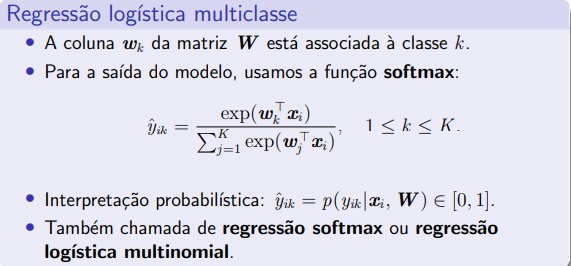

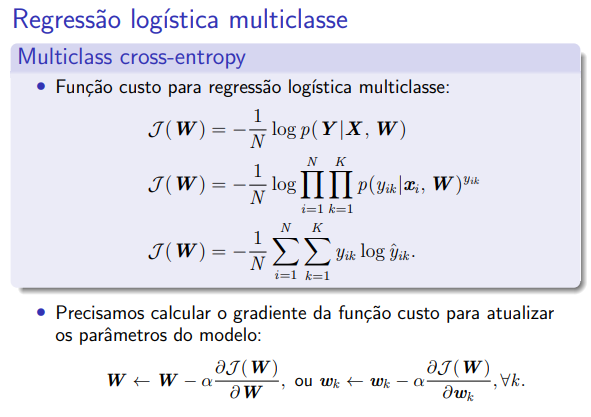

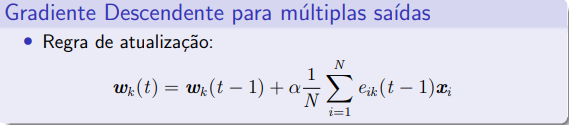

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionSoftmaxGD():
    def __init__(self, alfa, t=None):
        '''
        cria o modelo do tipo LogisticRegressionSoftmaxGD
        alfa (positive float): tamanho do passo em cada iteração, recomenda-se um valor pequeno
        t (int, optional): número de passos
        '''
        self.alfa = alfa
        self.t = 500 if t is None else t

    def softmax(self, z):
        """
        calcula a funcao softmax para um valor z
        """
        z = np.clip(z, -500, 500)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def plot_curva_aprendizado(self):
        '''
        cria um gráfico contabilizando os erros do modelo ao longo das épocas do modelo
        '''
        erros = self.erros
        plt.plot(erros)
        plt.xlabel('Iteração')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Curva de Aprendizado ao longo das Iterações')
        plt.show()

    def fit(self, train):
        '''
        faz o modelo se adequar ao conjunto de dados de treino
        x (np.array): array com o x do conjunto de dados
        y_true (np.array): valores verdadeiros de y do conjunto de dados
        '''
        x_train = train.iloc[:, :-1]
        y_train = train.iloc[:, -1].astype(int)


        num_classes = len(np.unique(y_train))
        y_train_one_hot = np.eye(num_classes)[y_train]

        # adicionando coluna de uns na esquerda de x_train
        x = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        y_train_one_hot = np.array(y_train_one_hot)

        # criando a matriz W
        W = np.random.randn(x.shape[1], num_classes) * 0.01
        lista_erros = []

        for j in range(self.t):
            # calcular as predições pelo modelo
            predicao = np.dot(x, W)
            y_pred = self.softmax(predicao)
            
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

            # atualizar o erro
            erro = y_pred - y_train_one_hot

            # atualizar os parâmetros
            W -= self.alfa * (1/x.shape[0]) * np.dot(x.T, erro)
            
            # calcular a cross-entropy loss
            cross_entropy_loss = -np.mean(np.sum(y_train_one_hot * np.log(y_pred), axis=1))
            lista_erros.append(cross_entropy_loss)
            
        self.W = W
        self.erros = lista_erros 

    def predict_probabilities(self, x_test):
        """
        retorna a probabilidade de cada item do conjunto de teste
        o valor sera entre 0 e 1
        """
        # pegar a matriz W que foi parametrizada e fitada no treino e aplicar para o conjunto de teste
        x = np.hstack((np.ones((x_test.shape[0], 1)), x_test))
        predicao = np.dot(x, self.W)
        return self.softmax(predicao)
    
    def predict(self, x_test):
        """
        retorna a predicao para os dados de teste
        """
        y_pred = self.predict_probabilities(x_test)
        return np.argmax(y_pred, axis=1)


# Questão 1

In [7]:
breast_cancer_data = pd.read_csv('breastcancer.csv')
breast_cancer_data = breast_cancer_data.sample(frac= 1).reset_index(drop = True)
x_breast_cancer = breast_cancer_data.iloc[:,:-1]
y_breast_cancer = breast_cancer_data.iloc[:,-1:]

## Regressão Logística

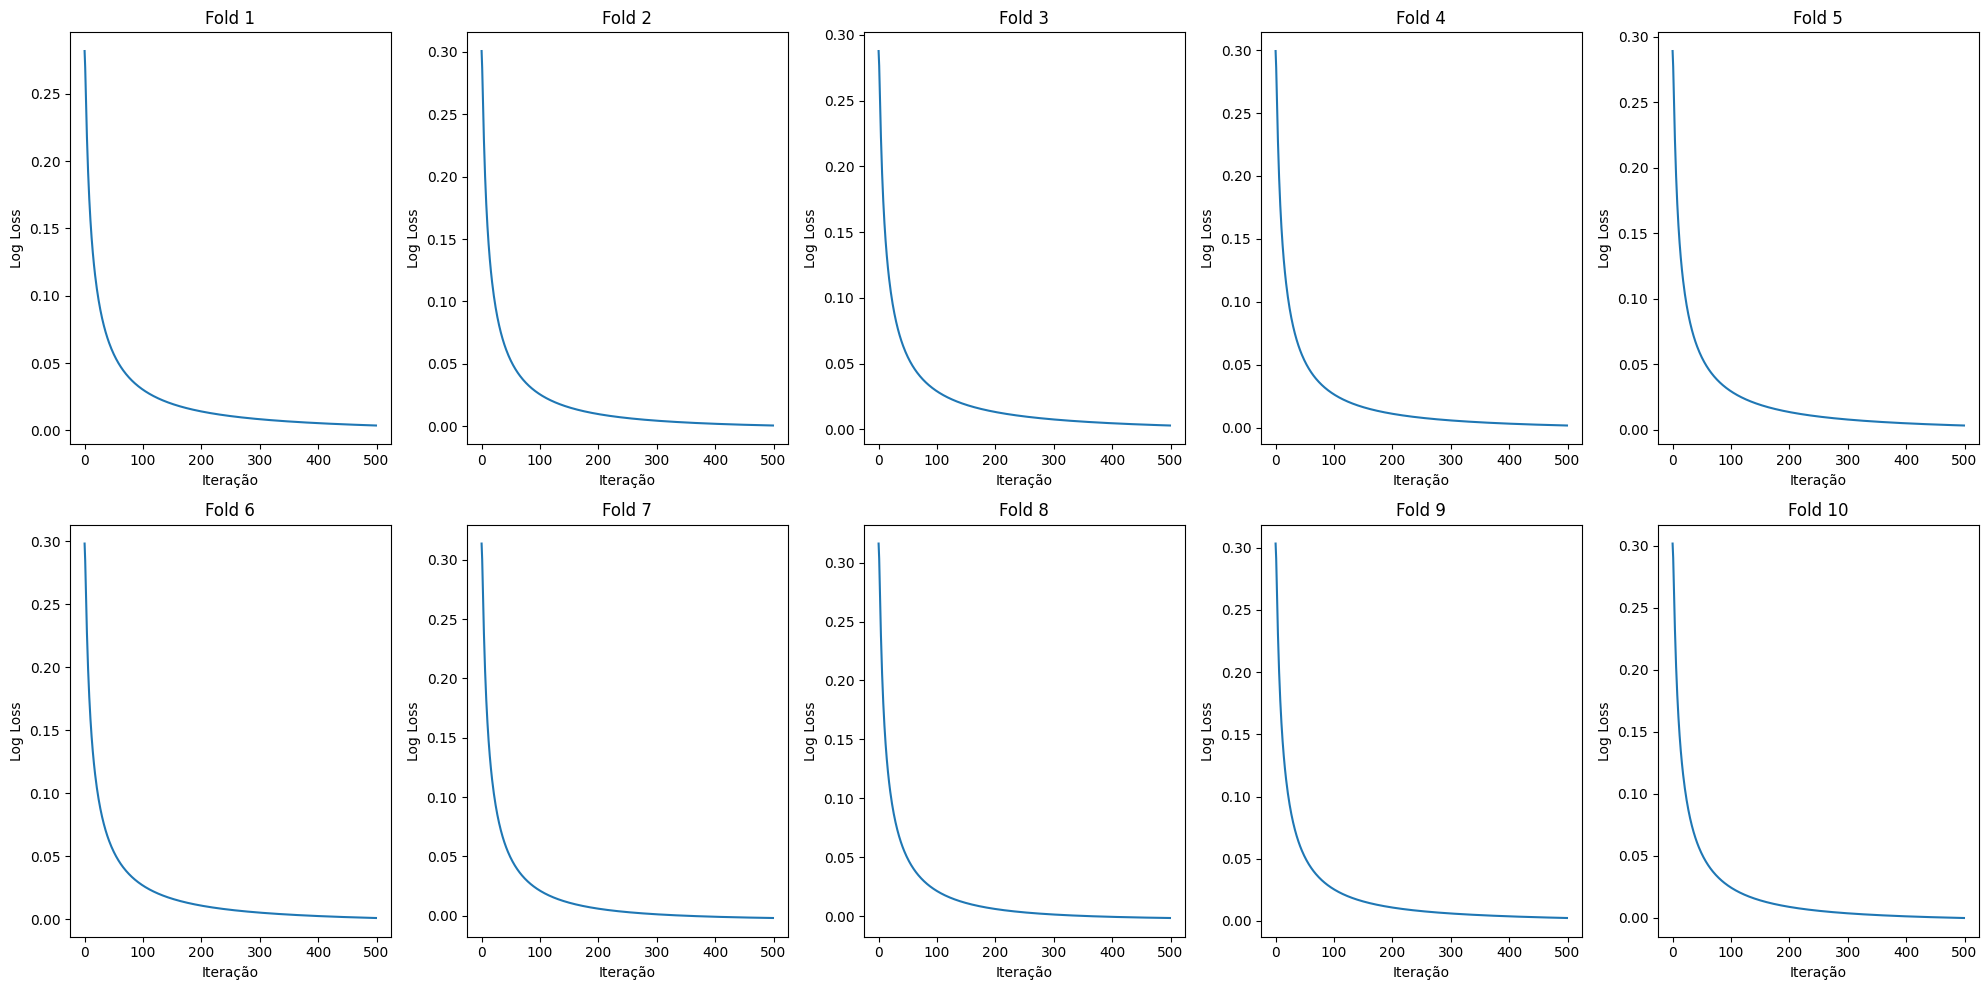

A acurácia para a classe 0.0 foi igual a 0.9890053258145363
A acurácia para a classe 1.0 foi igual a 0.9521589965251293
a acuracia global media do modelo foi igual a: 0.9771616541353383


In [8]:
regressao_logistica = LogisticRegressionGD(alfa= 0.1, t = 500)
#type(regressao_logistica)
kfold(model=regressao_logistica, features_data = x_breast_cancer, label_data= y_breast_cancer)


## Análise de Discriminante Gaussiano

In [9]:
discriminante = Discriminante_Gaussiano()
kfold(model=discriminante, features_data= x_breast_cancer, label_data= y_breast_cancer)

A acurácia para a classe 0.0 foi igual a 1.0
A acurácia para a classe 1.0 foi igual a 0.18048150129385826
a acuracia global media do modelo foi igual a: 0.6958646616541354


## Naive Bayes Gaussiano

In [10]:
naive = NaiveBayesGaussiano()
kfold(naive, x_breast_cancer, y_breast_cancer)

A acurácia para a classe 0.0 foi igual a 0.954171396628827
A acurácia para a classe 1.0 foi igual a 0.8912951196612523
a acuracia global media do modelo foi igual a: 0.9350250626566415


# Questão 2

In [11]:
vehicle = pd.read_csv('vehicle.csv')
vehicle = vehicle.sample(frac= 1).reset_index(drop = True)
x_vehicle = vehicle.iloc[:,:-1]
y_vehicle = vehicle.iloc[:,-1:]

## Regressão softmax

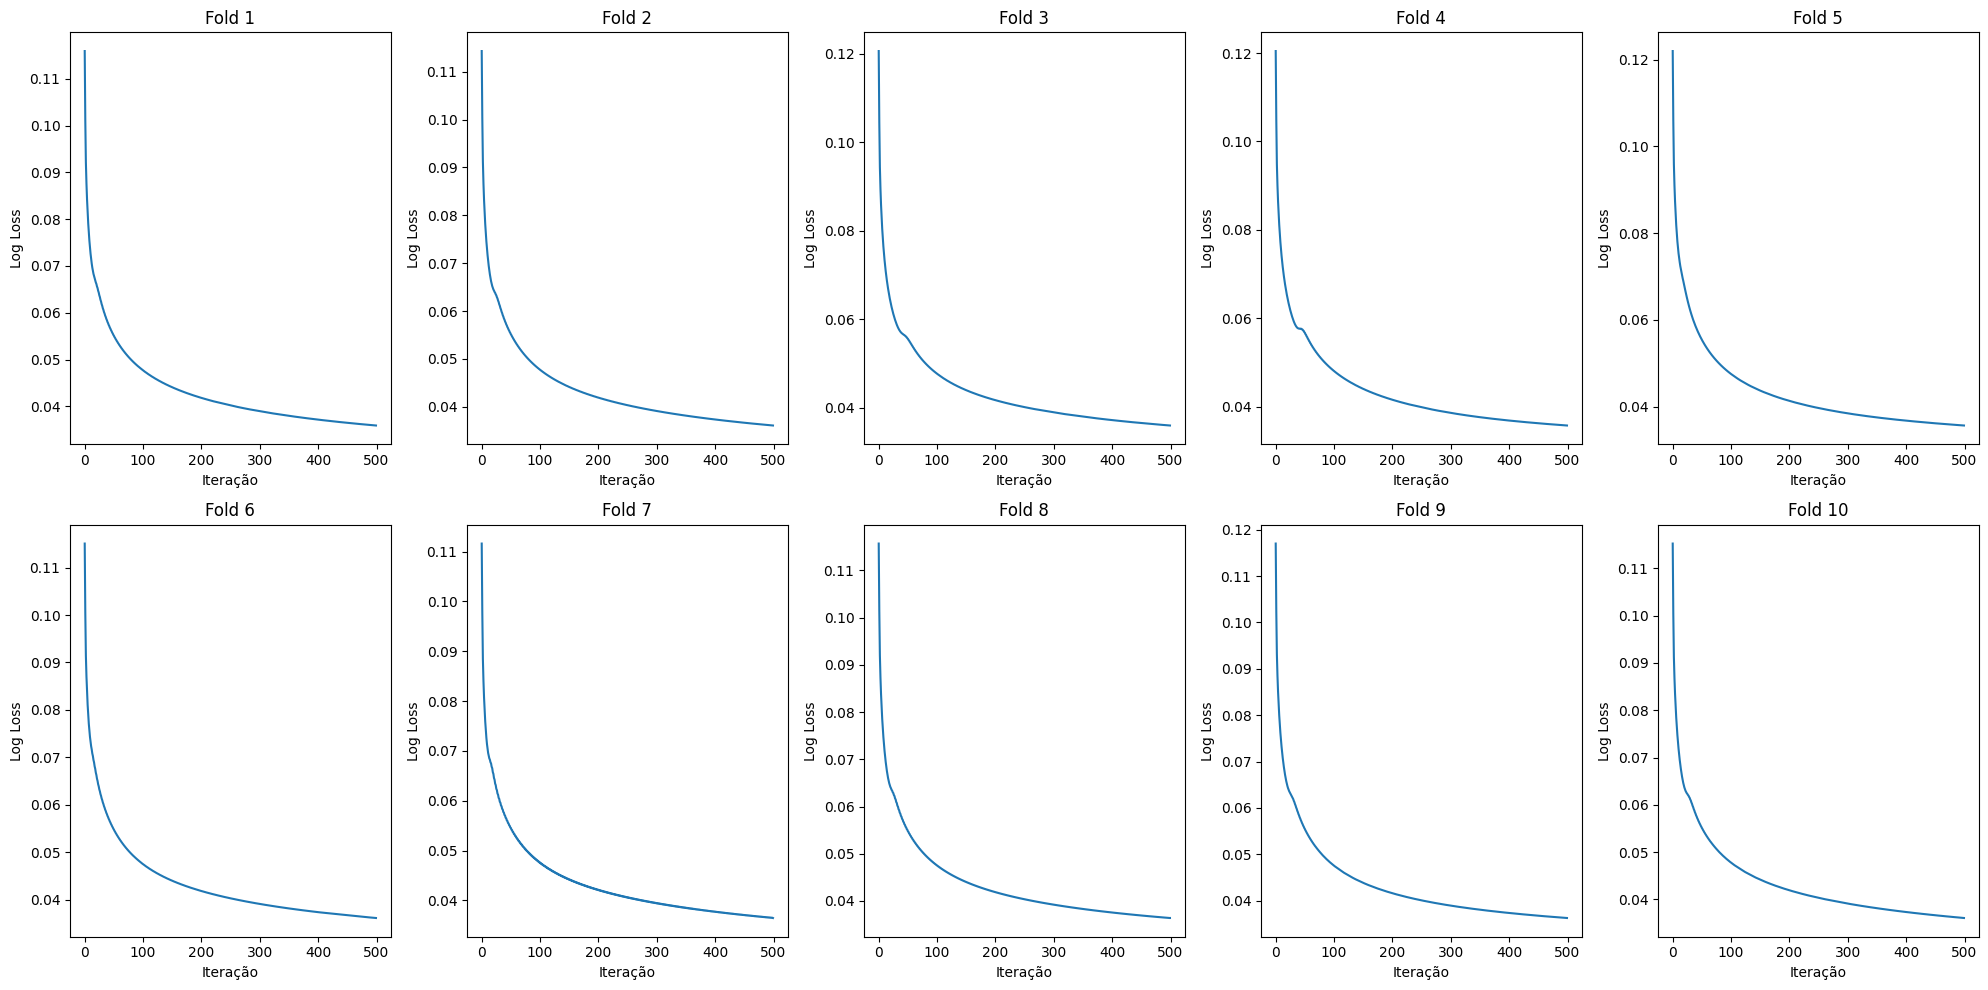

A acurácia para a classe 0.0 foi igual a 0.9425844712114735
A acurácia para a classe 1.0 foi igual a 0.5539586924868256
A acurácia para a classe 2.0 foi igual a 0.6544717510469967
A acurácia para a classe 3.0 foi igual a 0.969817920447211
a acuracia global media do modelo foi igual a: 0.7801307189542482


In [12]:
regressao_softmax = LogisticRegressionSoftmaxGD(alfa = 0.9)
kfold(model= regressao_softmax, features_data= x_vehicle, label_data= y_vehicle)

## Discriminante Gaussiano

In [13]:
discriminante = Discriminante_Gaussiano()
kfold(model = discriminante, features_data= x_vehicle,label_data=y_vehicle)

A acurácia para a classe 0.0 foi igual a 0.9598166716959623
A acurácia para a classe 1.0 foi igual a 0.11670796246947142
A acurácia para a classe 2.0 foi igual a 1.0
A acurácia para a classe 3.0 foi igual a 0.8126227995477582
a acuracia global media do modelo foi igual a: 0.7209005083514887


## Naive Bayes Gaussiano

In [14]:
naive = NaiveBayesGaussiano()
kfold(model = naive, features_data= x_vehicle,label_data=y_vehicle)

A acurácia para a classe 0.0 foi igual a 0.1474974758269953
A acurácia para a classe 1.0 foi igual a 0.4153019887188686
A acurácia para a classe 2.0 foi igual a 0.4001451868452811
A acurácia para a classe 3.0 foi igual a 0.8862665628703661
a acuracia global media do modelo foi igual a: 0.4560929557007989
